# Tutorial 4: Reactive Functions (Reactive Image Viewer)

In this tutorial, we will build a simple image viewer that shows a random subset of images from
a class in an image dataset.

Through this tutorial, you will learn about:
- the concept of **reactive functions** in Meerkat
- how **chaining reactive functions** together can be used to build complex applications
- a few more components that you can use in Meerkat

To get started, run the tutorial demo script.
```{code-block} bash
mk demo tutorial-reactive-viewer
```
You should see the tutorial app when you open the link in your browser.

Let's break down the code in the demo script.

## Data loading

The first few lines just load in the `imagenette` dataset, a small 10-class subset of ImageNet.
```{margin}
`df` is an `mk.DataFrame`, which behaves quite similarly to a `pandas.DataFrame`.
```

In [1]:
import meerkat as mk
import rich

df = mk.get("imagenette", version="160px")
IMAGE_COL = "img"
LABEL_COL = "label"

<!-- Show the dataset and hide the input cell. -->


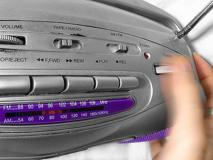
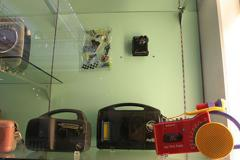
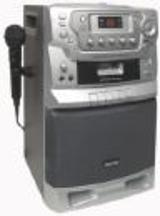
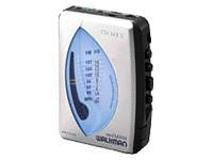
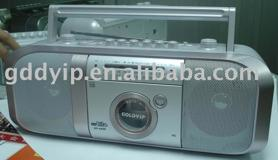

In [2]:
df.head()

In [3]:
# Unique classes in the dataset.
labels = list(df[LABEL_COL].unique())

In [4]:
rich.print(labels)

[
    'cassette player',
    'garbage truck',
    'tench',
    'english springer spaniel',
    'church',
    'parachute',
    'french horn',
    'chainsaw',
    'golf ball',
    'gas pump'
]

## Selecting a class

Next, let's create a {class}`~meerkat.gui.Select` component that allows the user to select a class. Once a user picks the class, we'll then show a random subset of images from that class.

```{margin}
A list of the components in Meerkat can be found in the
[component guide](../../guide/components/inbuilts.rst).
```

Meerkat provides many components like `Select` that can be used to build useful
apps.

In [5]:
# Give the user a way to select a class.
class_selector = mk.gui.Select(
    values=list(labels),
    value=labels[0],
)

In [6]:
rich.print(
    "[blue]class_selector.value[/blue]:", 
    f"\n\t{str(class_selector.value)}",
    "\n[blue]type(class_selector.value)[/blue]:", 
    f"\n\t{str(type(class_selector.value))}",
)

class_selector.value: 
        cassette player 
type(class_selector.value): 
        <class 'meerkat.interactive.graph.store.Store'>

Notice here that `class_selector.value` is a `Store` object and not a `str`! A `Store` is a special object in Meerkat that serves as a thin wrapper around any Python object. It's incredibly useful to connect different components to each other, and we'll see more about how it plays a role in the next section.


You can access the value of a `Store` object by using the `.value` attribute e.g.

In [7]:
rich.print(
    "[blue]class_selector.value.value[/blue]:", 
    f"\n\t{str(class_selector.value.value)}",
    "\n[blue]type(class_selector.value.value)[/blue]:", 
    f"\n\t{str(type(class_selector.value.value))}",
)

class_selector.value.value: 
        cassette player 
type(class_selector.value.value): 
        <class 'str'>

We can also look at the `class_selector` component itself.

In [8]:
rich.print(class_selector)

Select(
    values=Store(['cassette player', 'garbage truck', 'tench', 'english springer spaniel', 'church', 'parachute', 
'french horn', 'chainsaw', 'golf ball', 'gas pump']),
    labels=Store(['cassette player', 'garbage truck', 'tench', 'english springer spaniel', 'church', 'parachute', 
'french horn', 'chainsaw', 'golf ball', 'gas pump']),
    value=Store('cassette player'),
    disabled=Store(False),
    classes=Store(''),
    on_change=None,
    _slots=[],
    _self_id='__mkid__5ec9beda37e944068b55e1d67904c251'
)

Notice that all of the attributes of the `Select` component are also `Store` objects. This is done automatically by all classes that subclass `Component` in Meerkat, of which `Select` is one. This is very useful because as `Store` objects all of these attributes are synchronized between the frontend interface and the backend Python code.

## Filtering the dataset by class

Once the user selects a class, the dataset should be filtered to that class. 
**Importantly, we want this to happen every time the user selects a new class.**

Let's think about what would happen if we did the obvious thing and just filtered the dataset once.

In [9]:
# Filter the dataset to the selected class. Do it normally.
filtered_df = df[df[LABEL_COL] == class_selector.value]

In [10]:
rich.print(
    "[blue]filtered_df[/blue]:", 
    f"\n\t{str(filtered_df)}",
)

filtered_df: 
        DataFrame(nrows: 1350, ncols: 15)

The problem that will arise is that this filter uses the class label in `class_selector.value` **at the time of script execution. Once the user chooses a different class, there's no way to go back to this line of code and rerun it.**


This is where **reactive functions** come in. A reactive function is a function that is automatically re-executed whenever one of its inputs updates. 

In this example, we would want to re-execute the filter whenever the user selects a class and `class_selector.value` changes. Let's write a simple reactive function that filters the dataset to the selected class, using the {py:func}`@reactive() <meerkat.reactive>` decorator.

In [11]:
# Filter the dataset to the selected class. Use a reactive function.
@mk.reactive()
def filter_by_class(df: mk.DataFrame, label: str):
    return df[df[LABEL_COL] == label]

Note a couple of things here:
- The function `filter_by_class` is decorated with `@mk.reactive()`. This is what makes it reactive.
- `filter_by_class` is written as a normal Python function. This is true in general for reactive functions: there's no special syntax or anything.

Let's now call this reactive function on the dataset and the `Store` object `class_selector.value`.

In [12]:
filtered_df = filter_by_class(df, class_selector.value)

```{margin}
In Meerkat, only `marked` objects can cause a reactive function to re-execute when they are updated. All Meerkat objects have `.mark()` and `.unmark()` methods, and only `Store` objects are marked by default. You can read more about how this works in the [user guide on reactive functions](../../guide/reactive-functions/concepts.md).
```

When calling `filter_by_class`, we pass it the `DataFrame` and **the `Store` object `class_selector.value`, and not the actual string value of the class!** 
This is critical to understand: in order for an argument to trigger re-execution of a reactive function, it must be a Meerkat object like a `Store` or `DataFrame`, and not a Python object like `str`.

Of course, reactive functions can be used like normal Python functions, e.g. it would be perfectly fine to pass in `str` objects to `filter_by_class` instead of `Store` objects.


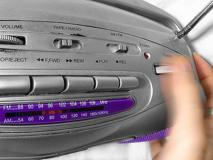
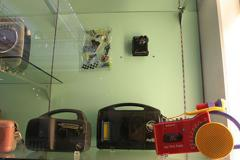
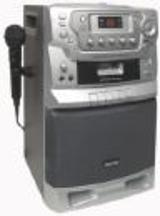
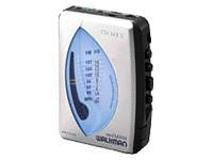
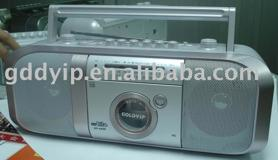
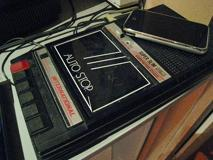
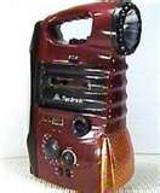
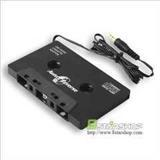
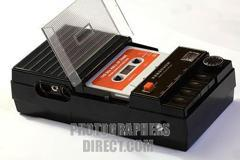
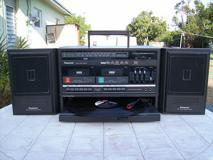

In [13]:
filter_by_class(df, "cassette player")

Let's also note a couple of other ways in which we could create reactive functions that wouldn't quite have worked.

In [14]:
@mk.reactive()
def filter_by_class(df: mk.DataFrame):
    return df[df[LABEL_COL] == class_selector.value]

Here, we've forgotten to create an argument for the class label, so using this reactive function would not work. It would never re-run when the user selects a new class!

So far so good. We've created and used a reactive function that filters the dataset to the selected class. 

## Selecting a random subset of images

Let's now create another reactive function that selects a random subset of images from the filtered dataset. Then, we'll chain together the two reactive functions we've created so far to get the final result.

In [15]:
"""Select a random subset of images from the filtered dataset."""
@mk.reactive()
def random_images(df: mk.DataFrame):
    # Sample 16 images from the filtered dataset.
    # `images` will be a `Column` object.
    images = df.sample(16)[IMAGE_COL]

    # Encode the images as base64 strings.
    # Use a `Formatter` object to do this.
    formatter = images.formatters['base']

    # All Formatter objects have an `encode` method that
    # can be used to take a data object and encode it in some way.
    return [formatter.encode(img) for img in images]

Here, `random_images` takes in a `DataFrame` and returns a list of base64-encoded images. It's decorated with `@mk.reactive()` so that it will be re-executed whenever the `DataFrame` is updated.

Let's pass the output of `filter_by_class` to `random_images`.

In [16]:
images = random_images(filtered_df)

In [17]:
rich.print(
    "[blue]images[/blue]:", 
    f"\n\t[{str(images[-1])}, ...]",
)

images:

This sets up a chain of reactive functions that will be re-executed whenever the user selects a new class.

## Displaying the images
Finally, let's show the user the images using a grid of `Image` components.

In [18]:
# Make a grid with 4 columns
grid = mk.gui.html.gridcols4([
    # Use equal-sized square boxes in the grid
    mk.gui.html.div(
        # Wrap the image in a `mk.gui.Image` component
        mk.gui.Image(data=img), 
        style="aspect-ratio: 1 / 1",
    )
    for img in images
], classes="gap-2") # Add some spacing in the grid.

Many components in Meerkat accept 
- a `classes` attribute that can be used to add Tailwind CSS classes to the component, and
- a `style` attribute that can be used to add inline CSS styles to the component.

Finally, let's use the `flexcol` component to stack the class selector and the grid of images vertically.

In [19]:
layout = mk.gui.html.flexcol([
    mk.gui.html.div(
        [mk.gui.Caption("Choose a class:"), class_selector], 
        classes="flex justify-center items-center mb-2 gap-4"
    ),
    grid,
])

We can pass everything into a `Page` component to render the app.

In [20]:
page = mk.gui.Page(component=layout, id="tutorial-2")
page.launch()

Frontend is not initialized. Running `mk.gui.start()`.

Downloading:   0%|          | 0.00/2.83M [00:00<?, ?B/s]

That's it!